# Natural Language Processing and Large Language Models

Graduate Quantitative Economics and Datascience

Jesse Perla (University of British Columbia)

# Overview

## Summary

-   Discuss text, NLP, and other embeddings
-   Relate embeddings to transformations like PCA
-   Use LLMs via the LangChain package

## References

-   These notes are a bare-bones introduction. See references for more
-   See Melissa Dell’s Survey [Deep Learning for
    Economists](https://arxiv.org/abs/2407.15339) and
    [Course](https://econdl.github.io/)
    -   [Topic and Sentiment
        Classification](https://econdl.github.io/intro/2023/03/22/lecture14.html)
    -   [Semantic and Syntactic
        Similarity](https://econdl.github.io/intro/2023/03/02/lecture11.html)

## API Options for LLMs

-   There are many ways to access these tools, including vendor-specific
    APIs and those which wrap things in as much of a cross-vendor way as
    possible
-   A big variation is between LLMs that are hosted and ones that run
    locally.
-   Local use of LLM/NLP is often facilitated by the package [Hugging
    Face Transformers](https://huggingface.co/docs/transformers/index)
    -   We will not use this approach here because it requires far more
        background, but if you are serious this is useful to know about
-   Remote use of LLMs can be done with
    -   Vendor specific APIs: e.g.,
        [OpenAI](https://platform.openai.com/docs/introduction)
    -   Cross-vendor packages: e.g.,
        [LangChain](https://python.langchain.com/docs/get_started/introduction.html)
        which calls out to OpenAI/Gemini/etc.

## Packages

-   For this introduction, we will use
    [LangChain](https://python.langchain.com/docs/get_started/introduction.html)
    to call out to OpenAI

In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

## OpenAI via LangChain

-   Sign up for the [OpenAI Platform](https://platform.openai.com/)
    -   Sometimes it is free for a limited number of tokens. See
        [pricing](https://openai.com/api/pricing/) for more
-   Go to the `API keys` tab and create a key
-   In your terminal, set `OPENAI_API_KEY` to this value (see
    [here](https://platform.openai.com/docs/quickstart?desktop-os=macOS#create-and-export-an-api-key))

## Creating the LangChain API

-   Instantiate models once (LangChain will pick up `OPENAI_API_KEY`
    from environment variable)
-   The `model=` might be chosen for speed, cost, etc.
-   Temperature is how random to make the output (0 = deterministic).
    Will discuss more later.

In [2]:
openai_embedding_model = "text-embedding-3-large"
openai_chat_model = "gpt-4o-mini"
llm = ChatOpenAI(model=openai_chat_model, temperature=0.7)
embedder = OpenAIEmbeddings(model=openai_embedding_model)

# Tokens, Vocabulary, and Corpus

## Tokens and Vocabulary

-   We can define a **vocabulary** of $K$ possible “tokens” enumerated
    $k = 1, \ldots, K$
    -   For NLP, this might be common words, parts of words, and
        characters.
    -   The vocabulary is model and sometimes application specific
-   A **splitter** will take an input and break it into pieces
    -   e.g., take a sentence and split on the whitespace
-   A **tokenizer** will take an input and map it into a sequence of
    token indices
    -   e.g., take a sentence, split on the spaces, and then map to
        tokens in the vocabulary
-   The **corpus** is the set of text/etc. you use
    -   In specialized cases you might want to build a custom vocabulary
        based on how common certain words are in your corpus

## Example with OpenAI Tokens

-   When using LLMs this sometimes happens in the background, but other
    times you may need more manual control
-   We can use a package to reverse-engineer what OpenAI does under the
    hood.
    -   Splits on whitespace, tokens may be whole words, subwords, or
        characters

In [3]:
enc = tiktoken.encoding_for_model(openai_embedding_model)
print(f"Tokens in vocabulary for {openai_embedding_model}: {enc.n_vocab}")
print(f"'Hello world' -> {enc.encode('Hello world')}")
print(f"'hello world' -> {enc.encode('hello world')}")
print(f"'hello world 67' -> {enc.encode('hello world 67')}")

Tokens in vocabulary for text-embedding-3-large: 100277
'Hello world' -> [9906, 1917]
'hello world' -> [15339, 1917]
'hello world 67' -> [15339, 1917, 220, 3080]

## Tasks with Tokens

-   Most tasks in NLP involve working with these tokenized inputs. For
    example,
    -   Simple counts of tokens (e.g., bag of words) for comparison
    -   Using a sequence of tokens as input to a model to predict the
        next token (or missing tokens)
    -   Mapping a sequence of tokens into an embedding of the entire
        sequence for similarity/classification/etc.
-   Not specific to text though. Can use with any sequence of discrete
    or discretized outcomes

## Embedding a Token

-   The ordering of the tokens from $k = 1, \ldots, K$ is arbitrary
-   However, we can assign a real-valued vector to each token
    -   This is called an **embedding** of the token and could capture
        things like conceptual similarity between them, etc.
    -   The real-valued vectors can then be clustered, classified, etc.

# Embeddings

## What is an Embedding?

In [4]:
resp = llm.invoke([
    SystemMessage(content="You provide 2 short bullet points, technical answers."),
    HumanMessage(content="What is an embedding?")
])
resp_text = resp.content
print(resp_text)

- An embedding is a dense vector representation of objects (like words, sentences, or images) in a continuous vector space, designed to capture semantic relationships and similarities.
- It converts high-dimensional data into lower-dimensional space while preserving essential features, often used in natural language processing and machine learning tasks for improved performance and interpretability.

## Detour into OpenAI (via LangChain)

-   Our code uses LangChain message objects to call OpenAI under the
    hood.
-   Message roles in LangChain and their OpenAI mapping:
    -   `SystemMessage` → OpenAI “system” role (sets
        behavior/instructions)
    -   `HumanMessage` → OpenAI “user” role (your prompt/query)
    -   `AIMessage` → OpenAI “assistant” role (model responses)
-   When building a conversation, you pass the entire message history
    (system + user + assistant) to the model each time; the model
    conditions on this full context.

## LLMs are Stateless

-   When you call `llm.invoke([...])` and related APIs you pass the
    entire history of the conversation each time.
-   This lets the model condition on the entire history to have
    history-contingent answers, and means it does not keep around a
    “state” or “memory” of the conversation.

## Followup: What does it have to do with Latent Spaces?

In [5]:
resp = llm.invoke([
    SystemMessage(content="You provide 2 short bullet points, technical answers."),
    HumanMessage(content="What is an embedding?"),
    AIMessage(content=resp_text),
    HumanMessage(content="What is the relationship to latent spaces?")
])
print(resp.content)

- Embeddings can be considered as representations of data points within a latent space, which is a lower-dimensional space that captures the underlying structure and patterns of the data.
- Latent spaces are often learned through models like autoencoders or generative adversarial networks (GANs), where embeddings serve as points in this space that facilitate tasks such as clustering, classification, or generation.

## Embeddings Overview

-   Used loosely and inconsistently, but the spirit is the same
-   A mapping of some $x \in \mathcal{X}$ to a latent space
    $\phi(x) \in \mathcal{Z}$
-   Typically we want that $\mathcal{Z}$ is a continuous vector space of
    finite dimension
    -   Crucially, we can think of distances in that space (e.g.,
        $||\phi(x) - \phi(y)||$)
-   The dimension of $\mathcal{Z}$ may be smaller or larger than
    $\mathcal{X}$
    -   If larger, typically in only small regions of the
        higher-dimensional space.
-   Often want to preserve norms in cases where the original space
    itself had a norm
    -   e.g., if $||x - y||$ is small, then $||\phi(x) - \phi(y)||$ is
        small

## Cosine Similarity

-   Cosine similarity is the “angle” between two vectors in the
    embedding space $z = \phi(x)$ and $z' = \phi(x')$ $$
    \mathrm{sim}(z, z') = \frac{z \cdot z'}{||z|| ||z'||}
    $$

## Interpretation of Cosine Similarity

-   Interpretation: If $z$ and $z'$ are
    1.  close in the embedding space, then the cosine similarity is
        close to 1
    2.  orthogonal, then the cosine similarity is 0
    3.  opposite, then the cosine similarity is -1
-   Norm comparison $||z - z'||$ instead? Works but not invariant to
    scaling

## Implementation of Cosine Similarity

In [6]:
def cos_sim(a, b):
  denom = np.linalg.norm(a) * np.linalg.norm(b)
  return np.dot(a, b) / denom
print(f"cos_sim([1, 0], [0, 1]) = {cos_sim(np.array([1, 0]), np.array([0, 1]))}")
print(f"cos_sim([1, 0], [0, 2]) = {cos_sim(np.array([1, 0]), np.array([0, 2]))}")
print(f"cos_sim([1, 0], [1, 0]) = {cos_sim(np.array([1, 0]), np.array([1, 0]))}")
print(f"cos_sim([1, 0], [2, 0]) = {cos_sim(np.array([1, 0]), np.array([2, 0]))}")
print(f"cos_sim([1, 0], [-2, 0]) = {cos_sim(np.array([1, 0]), np.array([-2, 0]))}")

cos_sim([1, 0], [0, 1]) = 0.0
cos_sim([1, 0], [0, 2]) = 0.0
cos_sim([1, 0], [1, 0]) = 1.0
cos_sim([1, 0], [2, 0]) = 1.0
cos_sim([1, 0], [-2, 0]) = -1.0

## Using LangChain OpenAI Embeddings

In [7]:
embed_bank = embedder.embed_query("bank")
embed_banks = embedder.embed_query("banks")
embed_river = embedder.embed_query("river")
embed_money = embedder.embed_query("money")
print(f"sim(bank, banks) = {cos_sim(embed_bank, embed_banks):.4f}")
print(f"sim(bank, river) = {cos_sim(embed_bank, embed_river):.4f}")
print(f"sim(bank, money) = {cos_sim(embed_bank, embed_money):.4f}")
print(f"sim(river, money) = {cos_sim(embed_river, embed_money):.4f}")

sim(bank, banks) = 0.7882
sim(bank, river) = 0.4143
sim(bank, money) = 0.4347
sim(river, money) = 0.3747

## Where Did the Embedding Come From?

-   OpenAI’s text embeddings (e.g., `text-embedding-3-large`) are
    trained with self-supervised objectives to produce general-purpose
    semantic vectors.
-   Conceptually, a representation map $\phi(x)$ is learned so that
    cosine similarity reflects semantic relatedness.
-   Always check provider docs for the training objective and intended
    use; not all embeddings are suitable for every task.

# Bigger Embeddings

## Bag of Words

-   Words usually occur in sentences, paragraphs, etc.
-   Instead of embedding a single word, we can embed a block of text.
-   Simple starting point: compare the relative frequency of words
    1.  Turn the text into blocks of tokens with unique identifiers
    2.  Filter out tokens that are not useful (e.g., “the”, “a”, etc.)
    3.  Count the frequency of each token
    4.  The embedding is the vector of the frequency of each token
-   Many issues with this, but crucially it does not capture any sense
    of context dependent meaning of words, and is invariant to word
    order

## Sentence Embeddings with LLMs

-   Encode an entire sentence into a single embedding and compare for
    similarity

In [8]:
e_1 = embedder.embed_query("The man bites the dog")
e_2 = embedder.embed_query("The dog chased the man")
e_3 = embedder.embed_query("The man was chased by the dog")
print(f"sim(e_1, e_2) = {cos_sim(e_1, e_2):.4f}")
print(f"sim(e_1, e_3) = {cos_sim(e_1, e_3):.4f}")
print(f"sim(e_2, e_3) = {cos_sim(e_2, e_3):.4f}")

sim(e_1, e_2) = 0.5413
sim(e_1, e_3) = 0.5225
sim(e_2, e_3) = 0.7911

-   Note that the 2nd and 3rd are the most similar, and the 1st and 3rd
    the least.

## Be Cautious, Interpretation is Tricky

In [9]:
e_1 = embedder.embed_query("The man bites the dog")
e_2 = embedder.embed_query("The dog chased the man")
e_3 = embedder.embed_query("The man was chased by the dog")
e_4 = embedder.embed_query("The man chased the dog")
print(f"sim(e_1, e_2) = {cos_sim(e_1, e_2):.4f}")
print(f"sim(e_1, e_3) = {cos_sim(e_1, e_3):.4f}")
print(f"sim(e_2, e_3) = {cos_sim(e_2, e_3):.4f}")
print(f"sim(e_3, e_4) = {cos_sim(e_3, e_4):.4f}")

sim(e_1, e_2) = 0.5415
sim(e_1, e_3) = 0.5227
sim(e_2, e_3) = 0.7911
sim(e_3, e_4) = 0.8598

-   Note that `sim(e_3, e_4) > sim(e_3, e_2)` even though they seem to
    have the exact opposite meaning!
-   Why? There are many embeddings (e.g. bag of words) which make these
    close, and others where they are far apart. Hard to know without a
    sense of how it was trained.

## Clustering/Visualization

-   Since embeddings provide a measure of similarity/distance, we can
    cluster it into groups or use other tools to find interpretations
-   There are various algorithms to cluster based on representations,
    and find the closest elements within the set of data for a new
    element
-   One approach for visualization: come up with a lower-dimensional
    embedding which approximately preserves local neighborhoods in 2D/3D
    as in [t-SNE (t-Distributed Stochastic Neighbor
    Embedding)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

## Get Some Random Embeddings

In [10]:
# Sample a small list of common words and embed them via OpenAIEmbeddings
sampled_tokens = [
  "bank", "river", "money", "finance", "water", "dog", "cat", "animal", "pet", "tree",
  "forest", "city", "village", "road", "car", "bus", "train", "doctor", "nurse", "hospital",
  "school", "student", "teacher", "book", "library", "music", "guitar", "piano", "art", "painting",
  "computer", "algorithm", "data", "model", "economics", "market", "price", "inflation", "policy",
  "riverbank", "beach", "mountain", "valley", "ocean", "lake", "software", "hardware", "network", "cloud"
]
embeddings = embedder.embed_documents(sampled_tokens)  # list[list[float]]
embeddings = np.array(embeddings)
print(f"collected {embeddings.shape[0]} embeddings of dimension {embeddings.shape[1]}")

collected 49 embeddings of dimension 3072

## Visualize with t-SNE

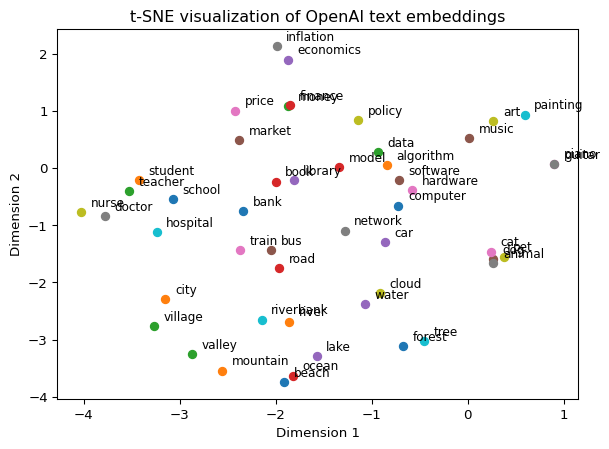

In [11]:
tsne = TSNE(n_components=2, random_state=0)  # approx with 2D embedding
embeddings_2d = tsne.fit_transform(embeddings)
# Plot the t-SNE results
plt.figure()
for i, token in enumerate(sampled_tokens):
    x, y = embeddings_2d[i]
    plt.scatter(x, y)
    plt.text(x+0.1, y+0.1, token, fontsize=9)
plt.title('t-SNE visualization of OpenAI text embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# Sequential Data and Token Prediction

## Distribution of Tokens

-   In many cases, data has an inherent sequential ordering. e.g. time
    series, language, etc.
-   Consider conditional probabilities over $x_t \in \{1, \ldots K\}$.
    Generically call these “tokens”
-   Objects of interest: for $x_1, x_2, \ldots, x_T$ for a sequence of
    length $T$ sampled from some population distribution
-   We may want to condition on the past to predict the next token,
    condition on the entire sequence to predict missing ones, etc.

## Multinomial Logit/Softmax

-   Often want to map a latent space to a probability distribution over
    $K$ outcomes

-   Given a set of $K$ outcomes, define the logit/softmax mapping a
    vector $y \in \mathbb{R}^K$ to a probability distribution over $K$
    outcomes as $$
    \mathrm{softmax}(y)_i = \frac{e^{y_i}}{\sum_{j=1}^K e^{y_j}}, \quad i = 1, \ldots, K
    $$

-   Typically this is combined with a mapping of a latent space,
    $z \in \mathbb{R}^L$, with some matrix
    $W \in \mathbb{R}^{K \times L}$ so that $\mathrm{softmax}(W z)$ is a
    probability distribution over $K$ outcomes

    $$
    \mathbb{P}\left(x = k | z\right) = \mathrm{softmax}(W z)_k
    $$

## Token Prediction from Conditional Probabilities

-   Given a sequence $x_1, x_2, \ldots, x_{t-1}$, model the conditional
    distribution: $$
    \mathbb{P}(x_t | x_{t-1}, x_{t-2}, \ldots, x_1)
    $$
    -   Where in the background these are done with marginal and
        conditional probabilities sampling the population distribution
-   Basic strategy for sequence models:
    1.  Do an embedding for each token $\phi_1(x_t)$
    2.  Map those embeddings to some combined representation,
        $\phi_2(\phi_1(x_1), \ldots, \phi_1(x_{t-1}))$
    3.  Map that with $\mathrm{softmax}$ to get probabilities over
        $k = 1, \ldots, K$ for $x_t$
    4.  Fit with methods such as maximum likelihood given the
        multinomial logit structure

## Provide Conditioning Tokens in the Prompt

-   See Melissa Dell’s
    [Prompting](https://www.dropbox.com/scl/fi/e8rnp61e9mv6es455f91c/lecture_prompting.pdf?rlkey=8mj1y59l3tjod34tp5vgk8akv&e=1&dl=0)
    lecture and [Prompts for
    Economists](https://sites.google.com/view/lastunen/ai-for-economists?authuser=0)

In [12]:
resp = llm.invoke([
    SystemMessage(content="You provide 2 short bullet points, technical answers."),
    HumanMessage(content="What is an embedding?")
])
resp_text = resp.content
print(resp_text)

- An embedding is a numerical representation of objects (like words, sentences, or images) in a continuous vector space, allowing for the capture of semantic relationships and similarities between those objects.
- This mapping typically preserves the contextual or relational properties of the data, enabling more effective machine learning tasks such as clustering, classification, or recommendation systems.

## Reminder: Concatenating Results

In [13]:
resp = llm.invoke([
    SystemMessage(content="You provide 2 short bullet points, technical answers."),
    HumanMessage(content="What is an embedding?"),
    AIMessage(content=resp_text),
    HumanMessage(content="What is the relationship to latent spaces?")
])
print(resp.content)

- Embeddings can be seen as a form of representation within a latent space, where the high-dimensional data is transformed into a lower-dimensional space that captures essential features and structures.
- Latent spaces facilitate the discovery of underlying patterns and relationships in data, with embeddings serving as specific points or vectors in these spaces that represent individual instances or features.

## Mental Model of Sequential Generation

1.  Start with a set of tokens, $x_1, x_2, \ldots, x_{t-1}$ (include
    **EVERYTHING**)
2.  Condition on those tokens to find the
    $\mathbb{P}(x_t | x_{t-1}, x_{t-2}, \ldots, x_1)$ distribution
3.  Sample from that to get the $x_t$ token
    -   “Temperature” setting mechanically increases/decreases the
        randomness for the logit (e.g., rescales $W z$)
4.  Add its own generated token to the set of tokens,
    $x_1, x_2, \ldots, x_{t-1}, x_t$
5.  Condition on those tokens to find the
    $\mathbb{P}(x_{t+1} | x_t, x_{t-1}, \ldots, x_1)$ distribution
6.  Repeat until it hits a special “done” token (itself predicted) or
    reaches a maximum length

## Cardinality of the Estimated Conditional Distribution

-   ChatGPT and others generate text token-by-token auto-regressively
-   No directly Markov. $K^T$ possible sequences of $K$ tokens of length
    $T$
-   Modest sized LLMs in 2025 might support $T=4,000$ with $K=50,000$
    tokens
    -   Estimating a
        $\mathbb{P} : 50,000 \times 50,000^{4,000}\to [0,1]$ conditional
        PMF
    -   And growing. Many recent models have supports $128k$ tokens for
        context (i.e., conditioning) and $16k$ for “output”

## How Can This Possibly Work?

-   It sometimes feels like it has compressed and memorized the entire
    internet
-   We don’t always know the parameterization or number of tokens in the
    training data (remember, this largely uses MLE to train) but
    OpenAI’s GPT-3 was disclosed
    -   The $\mathbb{P}(\cdot | \cdot)$ is approximated by approximating
        175 billion parameters
    -   Trained on 300 billion tokens from close to a terabyte of
        cleaned text
-   Which is an **absurdly small amount of data** given the cardinality
    of $\mathbb{P}$
    -   Paraphrasing Mikhail Belkin: this is like estimating the Library
        of Congress with a molecule of ink.